In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression
from sklearn.metrics import root_mean_squared_error
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import PolynomialFeatures, StandardScaler, KBinsDiscretizer
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.decomposition import PCA

from src.feature_engineering import *

import warnings
warnings.filterwarnings("ignore")

In [2]:
#config
DATA_PATH = "data/"

### Feature Engineering

Feature Ideas : 

- Outlier handling
- Standardization
- Feature binning
- Add polynomial features

In [3]:
df = pd.read_csv(DATA_PATH + "train.csv")
print(df.shape)
df.head(3)

(524164, 11)


,id,RhythmScore,AudioLoudness,VocalContent,AcousticQuality,InstrumentalScore,LivePerformanceLikelihood,MoodScore,TrackDurationMs,Energy,BeatsPerMinute
0,0,0.603610,-7.636942,0.023500,0.000005,0.000001,0.051385,0.409866,290715.6450,0.826267,147.53020
1,1,0.639451,-16.267598,0.071520,0.444929,0.349414,0.170522,0.651010,164519.5174,0.145400,136.15963
2,2,0.514538,-15.953575,0.110715,0.173699,0.453814,0.029576,0.423865,174495.5667,0.624667,55.31989


In [4]:
feature_cols = df.drop(columns=['id', 'BeatsPerMinute']).columns.tolist()
feature_cols

['RhythmScore',
 'AudioLoudness',
 'VocalContent',
 'AcousticQuality',
 'InstrumentalScore',
 'LivePerformanceLikelihood',
 'MoodScore',
 'TrackDurationMs',
 'Energy']

Outlier Handling

Reason : Keeps extreme values from dominating statistics

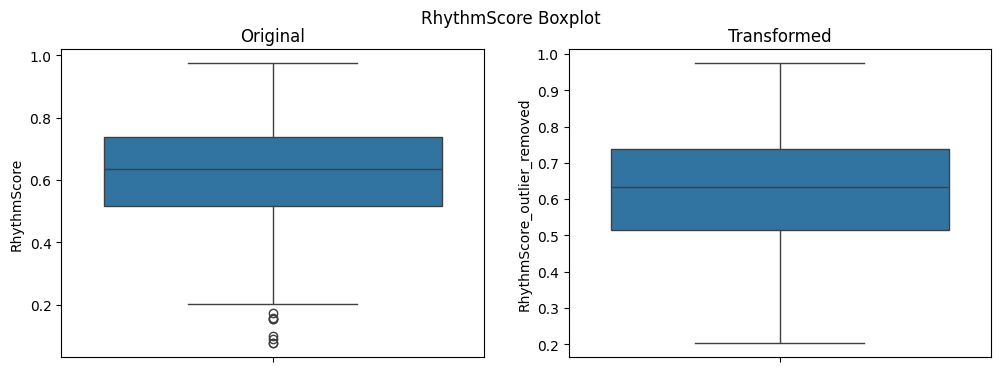

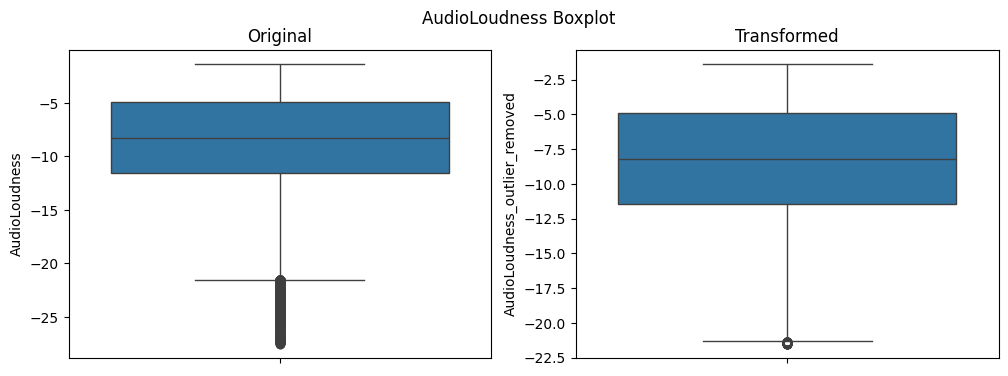

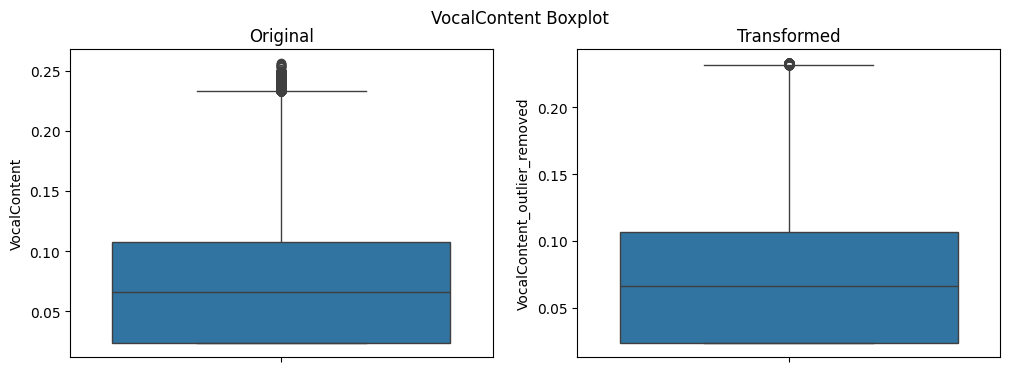

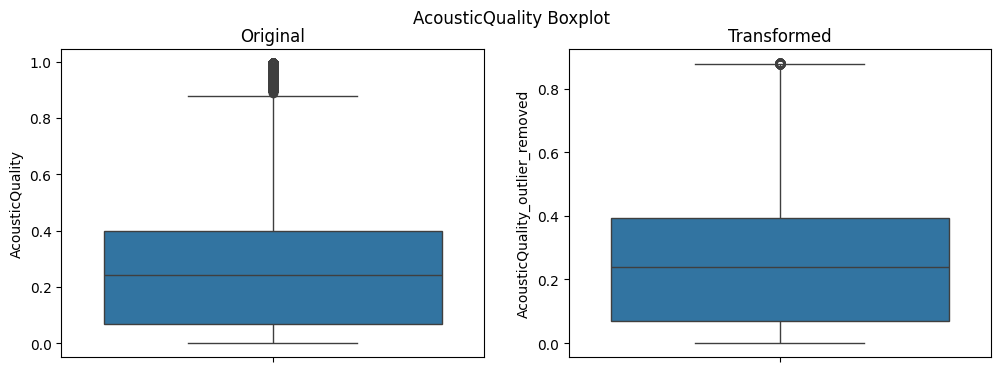

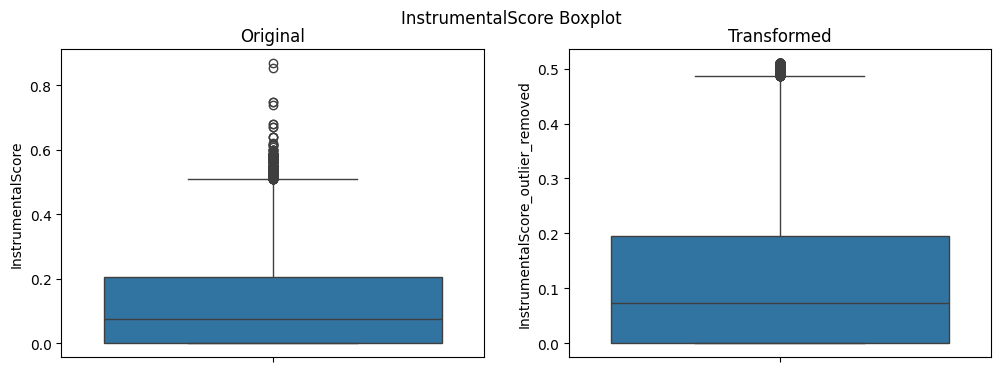

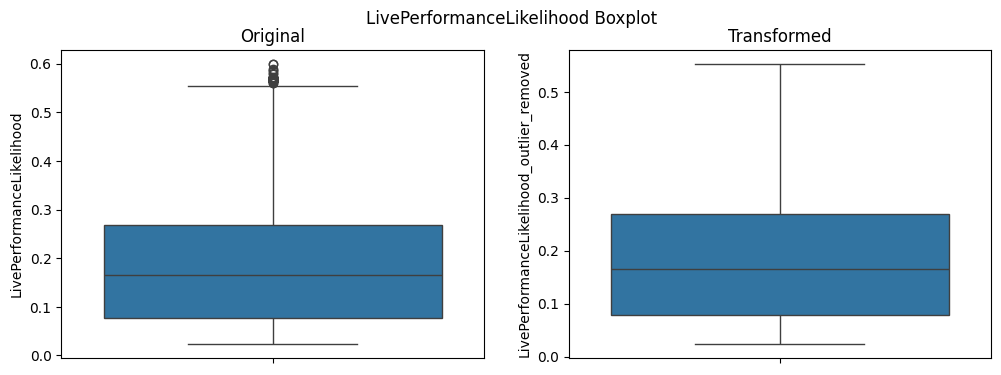

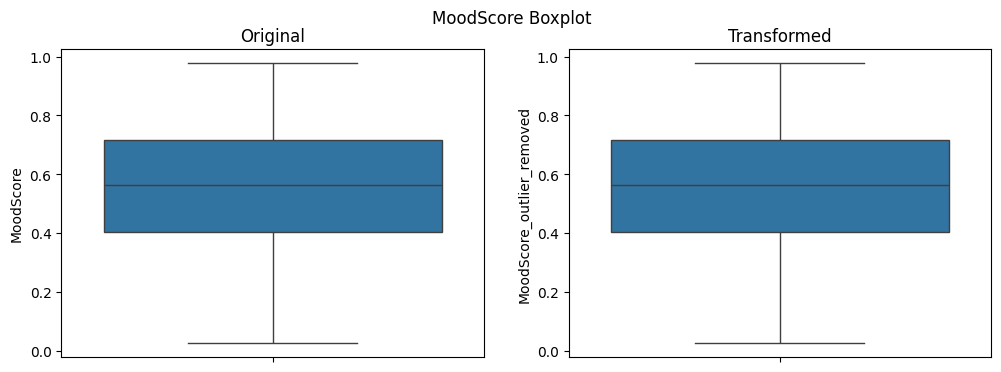

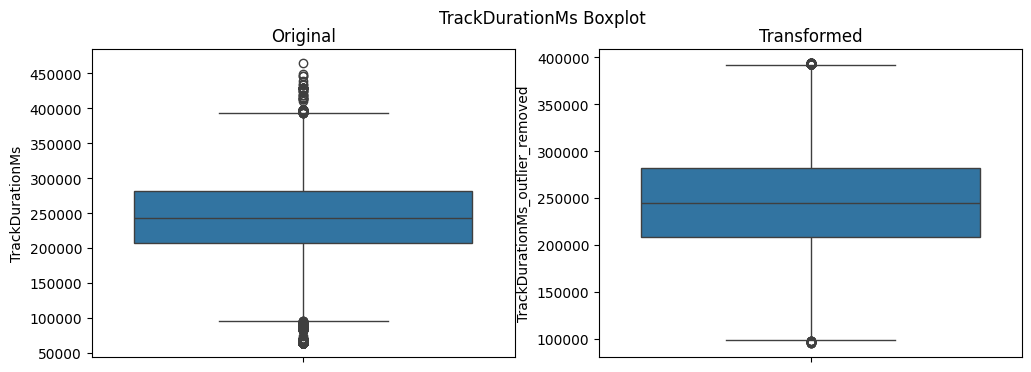

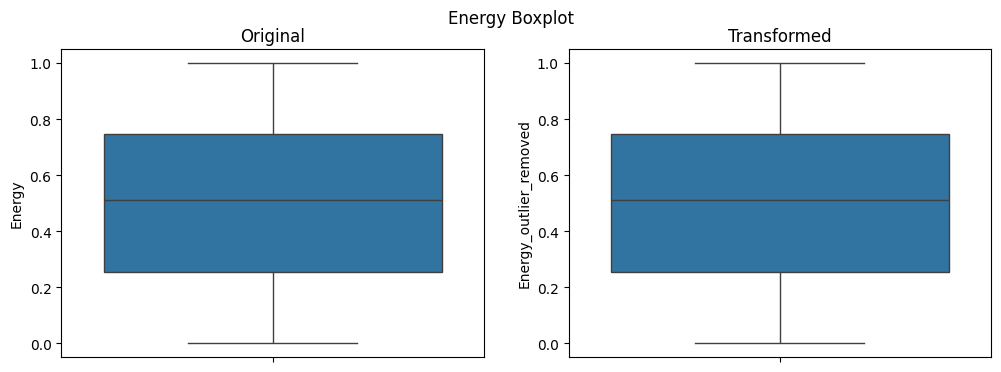

In [5]:
for feature in feature_cols:
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))

    fig.suptitle(f"{feature} Boxplot")
    ax1.set_title("Original")
    sns.boxplot(df[feature], ax=ax1)

    #outlier removal with IQR method (remove values outside [Q1 - k*IQR, Q3 + k*IQR])
    q1 = df[feature].quantile(0.25)
    q3 = df[feature].quantile(0.75)
    iqr = q3 - q1
    k = 1.5
    lower_bound = q1 - iqr*k
    upper_bound = q3 + iqr*k
    df[f"{feature}_outlier_removed"] = np.where(
        (df[feature]<lower_bound)|(df[feature]>upper_bound),
        np.nan,
        df[feature]
    )

    ax2.set_title("Transformed")
    sns.boxplot(df[f"{feature}_outlier_removed"], ax=ax2)
    plt.show()

Standardization

Reason : puts all features on the same scale

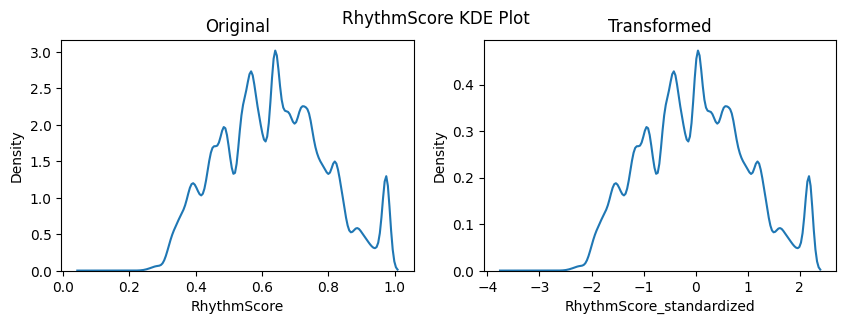

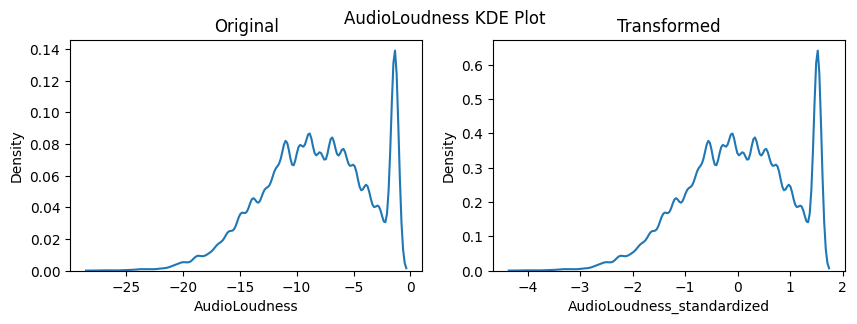

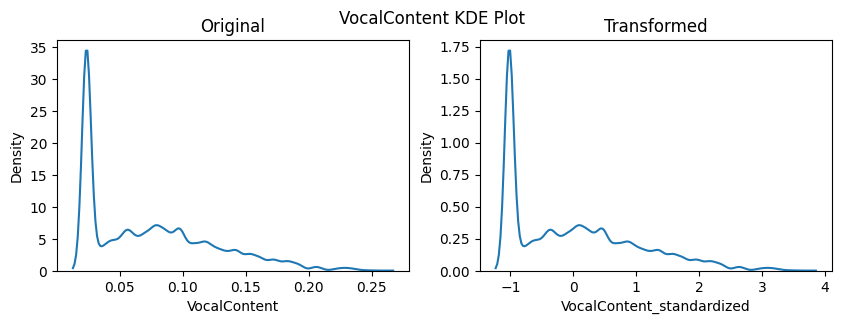

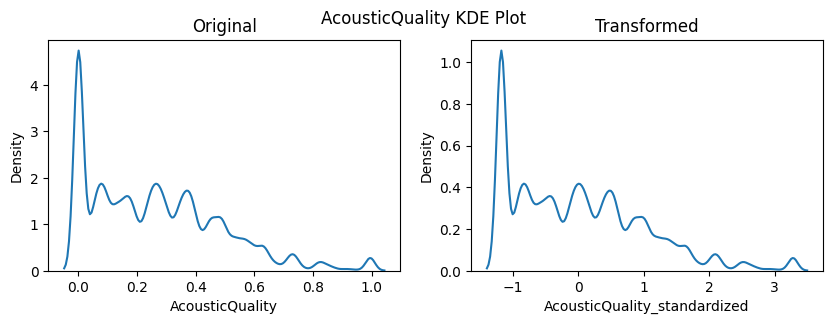

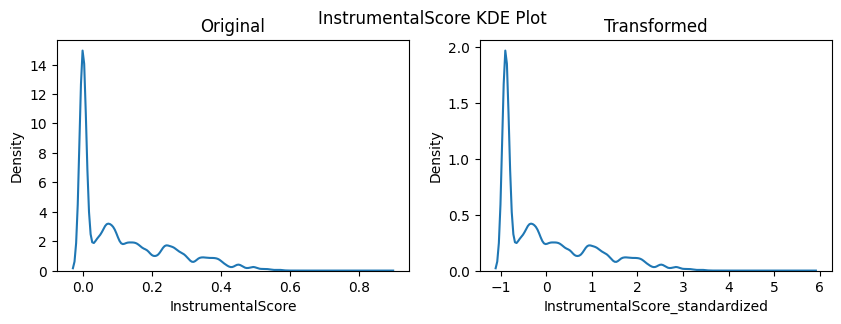

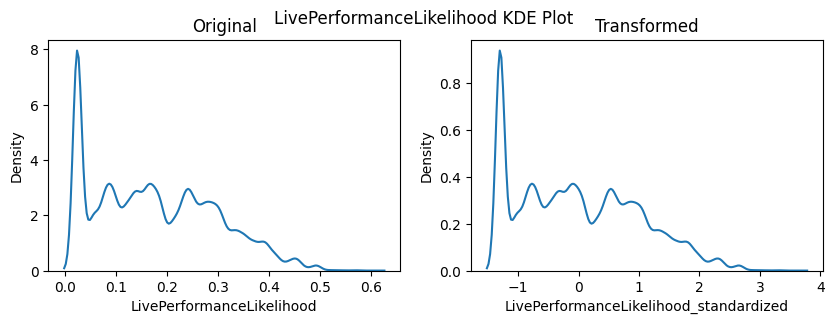

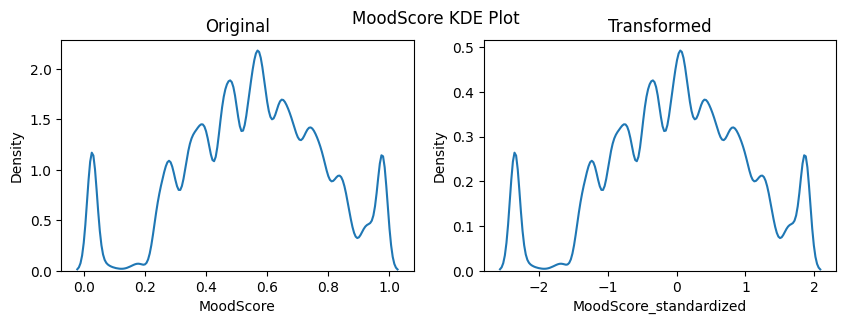

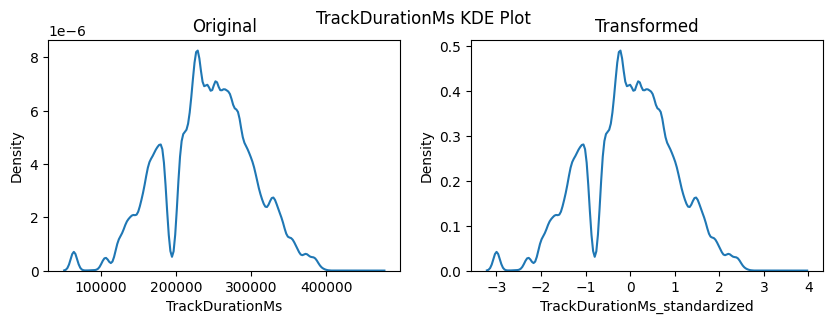

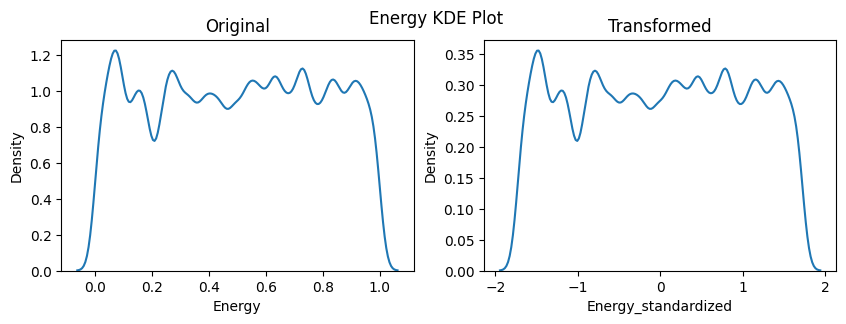

In [6]:
for feature in feature_cols:
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 3))

    fig.suptitle(f"{feature} KDE Plot")
    ax1.set_title("Original")
    sns.kdeplot(df[feature], ax=ax1)

    scaler = StandardScaler()
    df[f"{feature}_standardized"] = scaler.fit_transform(df[[feature]])

    ax2.set_title("Transformed")
    sns.kdeplot(df[f"{feature}_standardized"], ax=ax2)
    plt.show()

Feature binning

Reason : reduce the effect of outliers

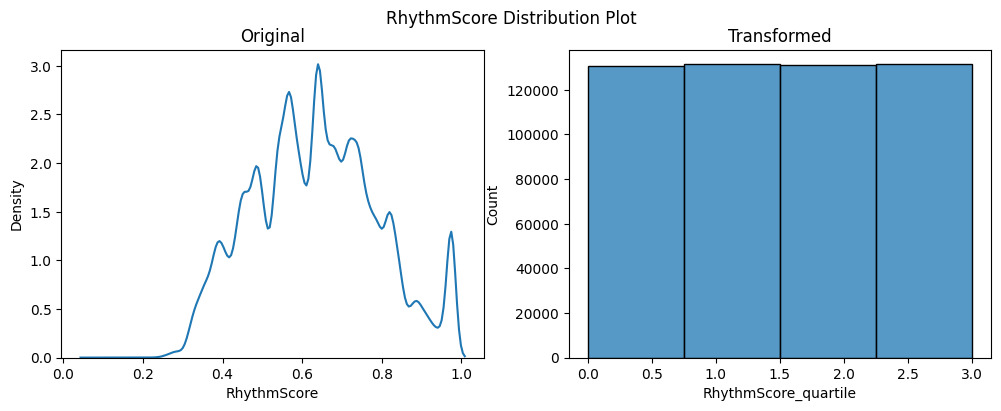

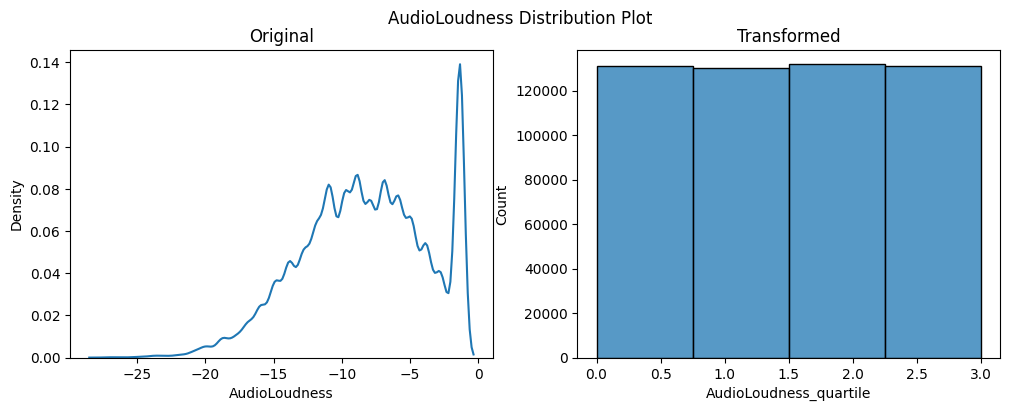

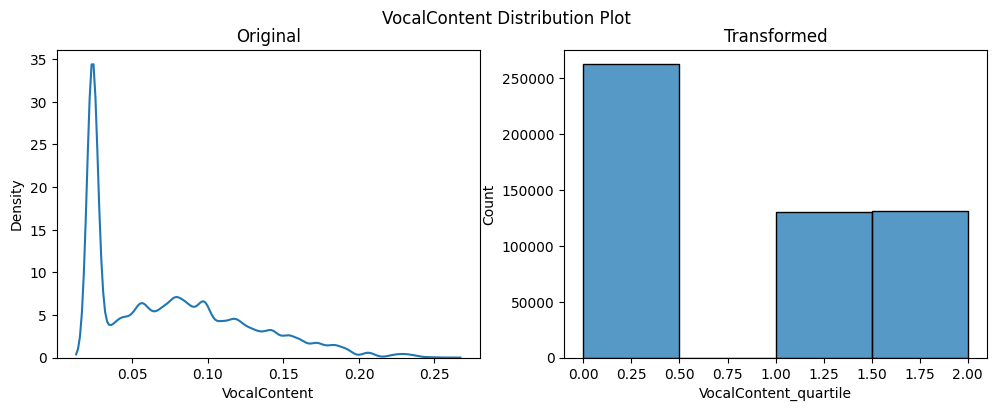

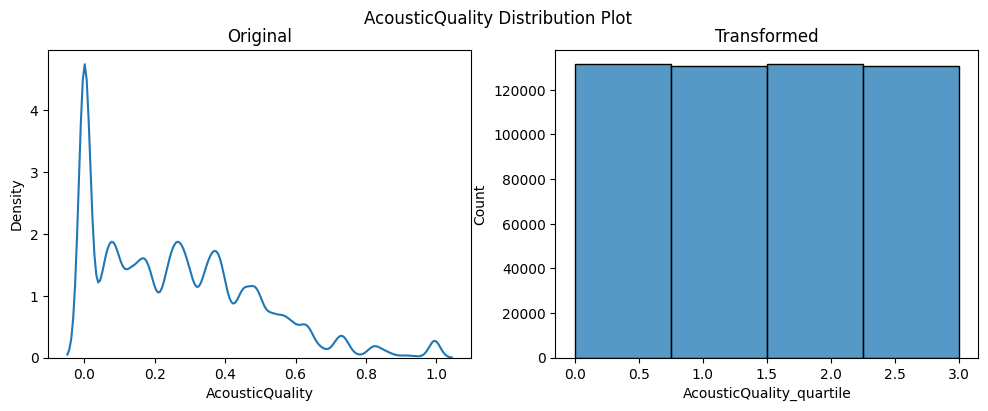

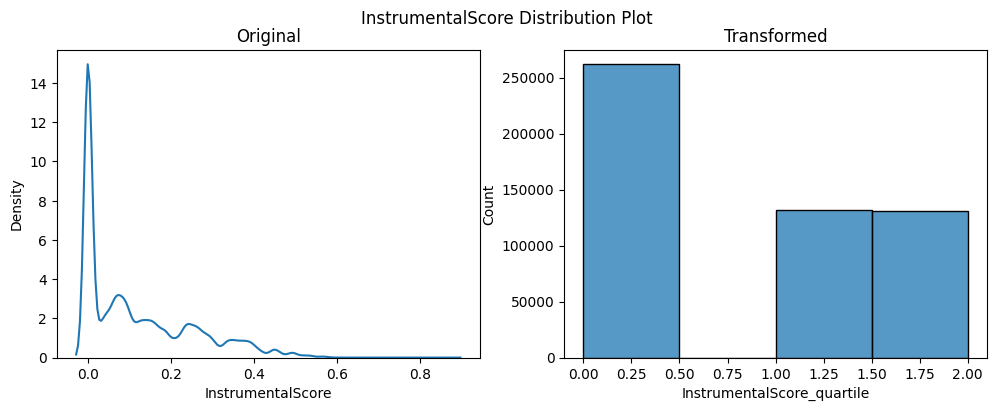

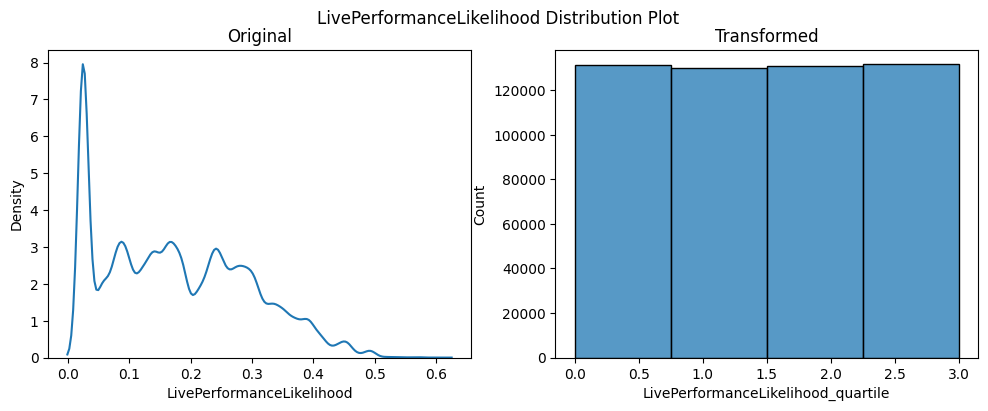

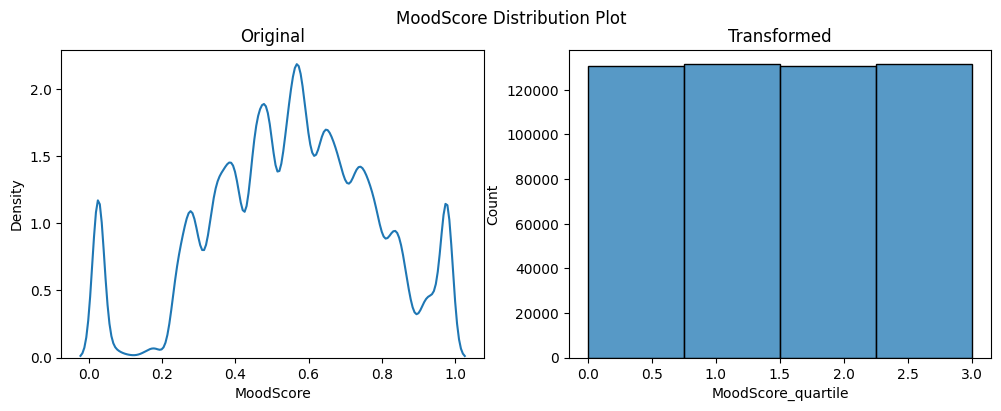

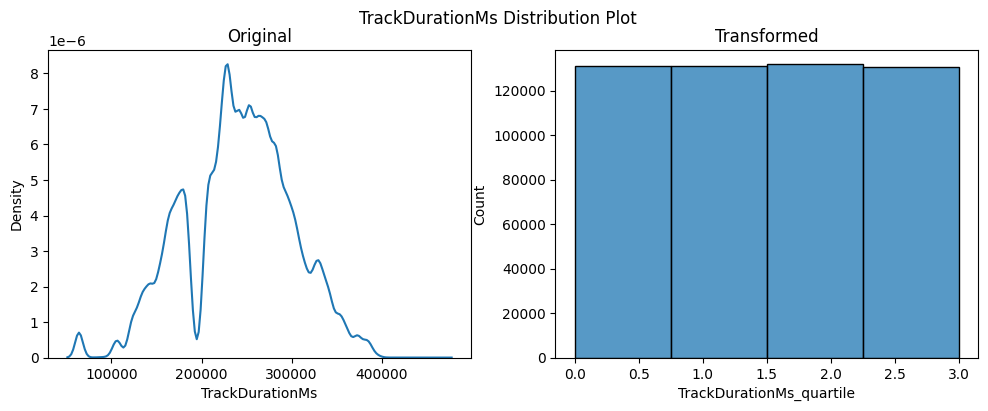

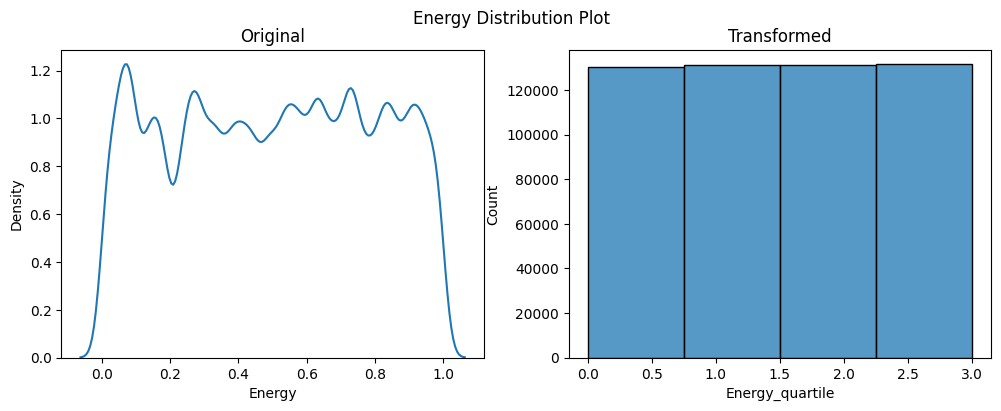

In [7]:
for feature in feature_cols:
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))

    fig.suptitle(f"{feature} Distribution Plot")
    ax1.set_title("Original")
    sns.kdeplot(df[feature], ax=ax1)

    n_bins=4
    kb = KBinsDiscretizer(n_bins=n_bins, encode='ordinal', strategy='quantile', quantile_method='linear')
    df[f"{feature}_quartile"] = kb.fit_transform(df[[feature]])

    ax2.set_title("Transformed")
    sns.histplot(df[f"{feature}_quartile"], bins=n_bins, ax=ax2)
    plt.show()

Add polynomial features

Reason : helps linear models capture nonlinear relationships and feature interactions

In [8]:
# Polynomial features (degree=2 adds x^2 and x1*x2)
poly = PolynomialFeatures(degree=2, interaction_only=False, include_bias=False)
poly_features = poly.fit_transform(df[feature_cols])
df_poly = pd.DataFrame(poly_features, columns=poly.get_feature_names_out())
print(df_poly.shape)
df_poly.head(3)

(524164, 54)


,RhythmScore,AudioLoudness,VocalContent,AcousticQuality,InstrumentalScore,LivePerformanceLikelihood,MoodScore,TrackDurationMs,Energy,RhythmScore^2,...,LivePerformanceLikelihood^2,LivePerformanceLikelihood MoodScore,LivePerformanceLikelihood TrackDurationMs,LivePerformanceLikelihood Energy,MoodScore^2,MoodScore TrackDurationMs,MoodScore Energy,TrackDurationMs^2,TrackDurationMs Energy,Energy^2
0,0.603610,-7.636942,0.023500,0.000005,0.000001,0.051385,0.409866,290715.6450,0.826267,0.364345,...,0.002640,0.021061,14938.555985,0.042458,0.167990,119154.533849,0.338659,8.451559e+10,240208.647039,0.682717
1,0.639451,-16.267598,0.071520,0.444929,0.349414,0.170522,0.651010,164519.5174,0.145400,0.408898,...,0.029078,0.111012,28054.252260,0.024794,0.423814,107103.892481,0.094657,2.706667e+10,23921.137830,0.021141
2,0.514538,-15.953575,0.110715,0.173699,0.453814,0.029576,0.423865,174495.5667,0.624667,0.264749,...,0.000875,0.012536,5160.810385,0.018475,0.179662,73962.556399,0.264774,3.044870e+10,109001.564057,0.390208


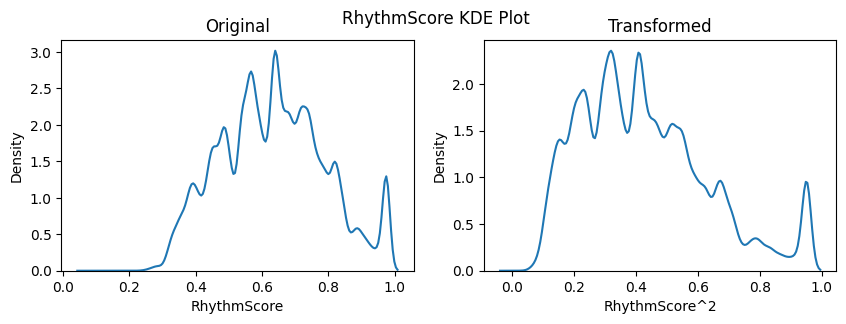

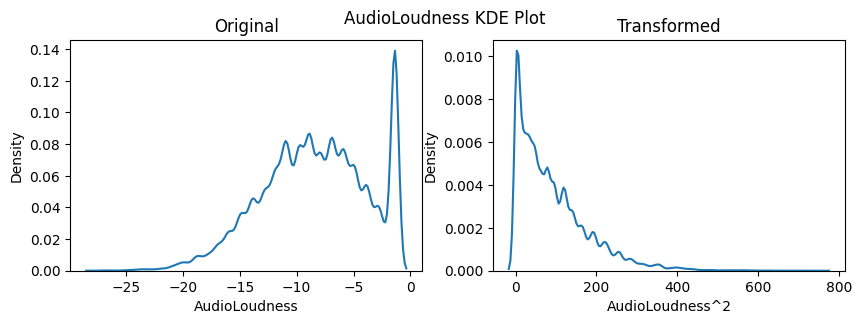

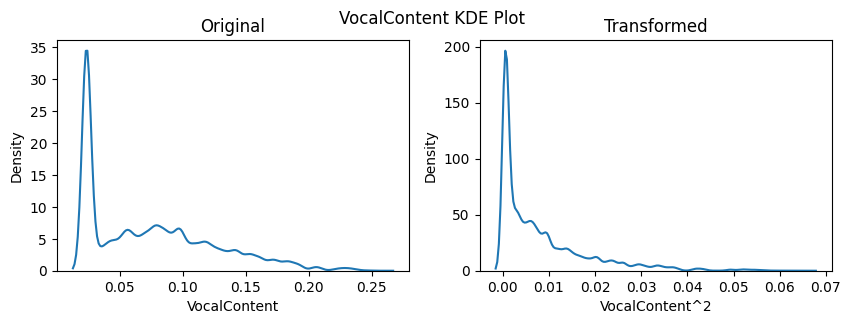

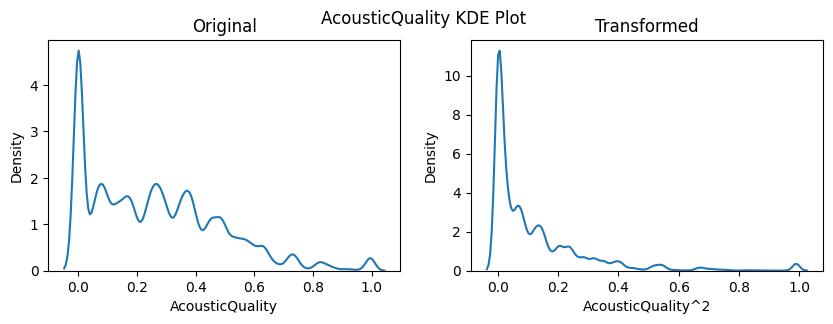

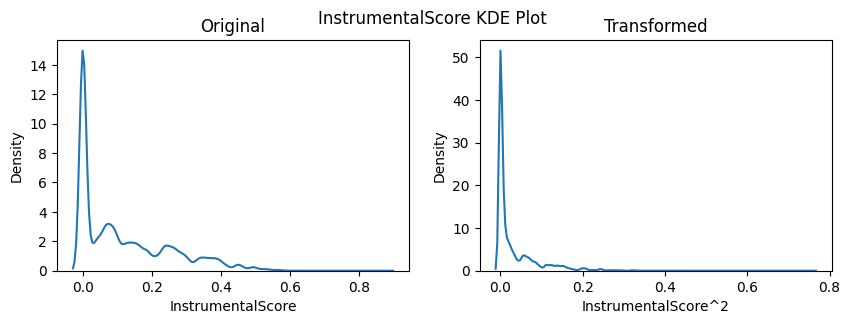

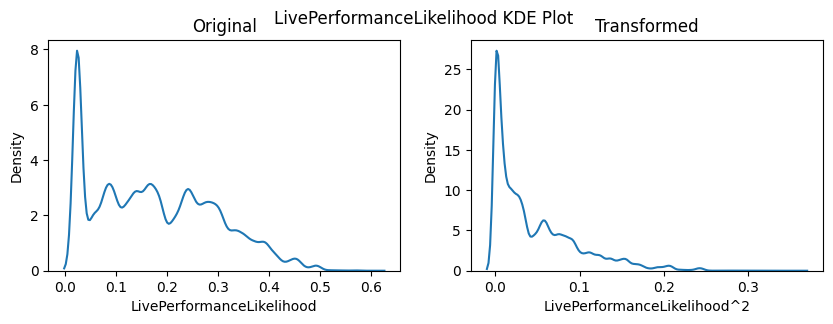

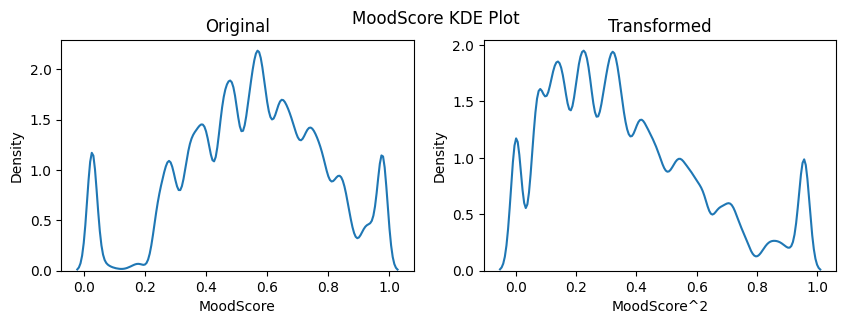

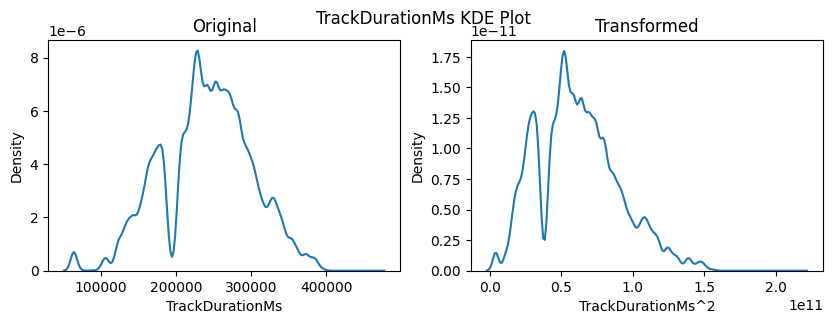

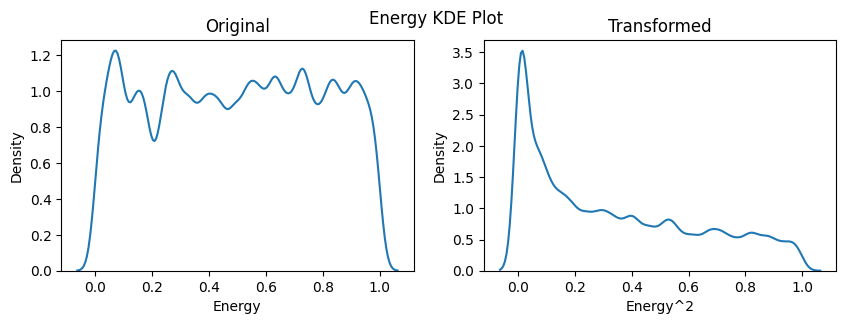

In [9]:
for feature in feature_cols:
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 3))

    fig.suptitle(f"{feature} KDE Plot")
    ax1.set_title("Original")
    sns.kdeplot(df_poly[feature], ax=ax1)

    ax2.set_title("Transformed")
    sns.kdeplot(df_poly[f"{feature}^2"], ax=ax2)
    plt.show()

### Testing New Features Performance

In [10]:
df = pd.read_csv(DATA_PATH + "train.csv")
print(df.shape)
df.head(3)

(524164, 11)


,id,RhythmScore,AudioLoudness,VocalContent,AcousticQuality,InstrumentalScore,LivePerformanceLikelihood,MoodScore,TrackDurationMs,Energy,BeatsPerMinute
0,0,0.603610,-7.636942,0.023500,0.000005,0.000001,0.051385,0.409866,290715.6450,0.826267,147.53020
1,1,0.639451,-16.267598,0.071520,0.444929,0.349414,0.170522,0.651010,164519.5174,0.145400,136.15963
2,2,0.514538,-15.953575,0.110715,0.173699,0.453814,0.029576,0.423865,174495.5667,0.624667,55.31989


In [11]:
#for testing purposes, sample for faster iteration
df_sample = df.sample(frac=0.10, random_state=1)

X = df_sample.drop(columns=['id', 'BeatsPerMinute'])
y = df_sample['BeatsPerMinute']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=1)
print(X_train.shape)
print(X_test.shape)

(41932, 9)
(10484, 9)


In [12]:
numeric_features = feature_cols
numeric_features

['RhythmScore',
 'AudioLoudness',
 'VocalContent',
 'AcousticQuality',
 'InstrumentalScore',
 'LivePerformanceLikelihood',
 'MoodScore',
 'TrackDurationMs',
 'Energy']

In [15]:
#compare the performance on tree-based model

#baseline model
model_baseline = RandomForestRegressor(n_estimators=100, random_state=1)
model_baseline.fit(X_train, y_train)
y_preds_baseline = model_baseline.predict(X_test)

model_outlier = get_custom_pipeline(
    numeric_features,
    model_baseline,
    outlier=True,
    scaler=False,
    poly=False,
    binning=False
)
model_outlier.fit(X_train, y_train)
y_preds_outlier = model_outlier.predict(X_test)

model_scaler = get_custom_pipeline(
    numeric_features,
    model_baseline,
    outlier=False,
    scaler=True,
    poly=False,
    binning=False
)
model_scaler.fit(X_train, y_train)
y_preds_scaler = model_scaler.predict(X_test)

model_poly = get_custom_pipeline(
    numeric_features,
    model_baseline,
    outlier=False,
    scaler=False,
    poly=True,
    binning=False
)
model_poly.fit(X_train, y_train)
y_preds_poly = model_poly.predict(X_test)

model_binning = get_custom_pipeline(
    numeric_features,
    model_baseline,
    outlier=False,
    scaler=False,
    poly=False,
    binning=True
)
model_binning.fit(X_train, y_train)
y_preds_binning = model_binning.predict(X_test)

model_combined = get_custom_pipeline(
    numeric_features,
    model_baseline,
    outlier=True,
    scaler=True,
    poly=True,
    binning=True
)
model_combined.fit(X_train, y_train)
y_preds_combined = model_combined.predict(X_test)

rf_rmse_result_dict = {
    "baseline" : root_mean_squared_error(y_test, y_preds_baseline),
    "outlier" : root_mean_squared_error(y_test, y_preds_outlier),
    "scaler" : root_mean_squared_error(y_test, y_preds_scaler),
    "poly" : root_mean_squared_error(y_test, y_preds_poly),
    "binning" : root_mean_squared_error(y_test, y_preds_binning),
    "combined" : root_mean_squared_error(y_test, y_preds_combined),
}
rf_rmse_result_dict

{'baseline': 26.868351253398114,
 'outlier': 31.57356985154875,
 'scaler': 26.84248324255374,
 'poly': 31.602370183848063,
 'binning': 28.698963632175026,
 'combined': 26.727526630921666}

In [16]:
#compare the performance on linear model

#baseline model
model_baseline = LinearRegression()
model_baseline.fit(X_train, y_train)
y_preds_baseline = model_baseline.predict(X_test)

model_outlier = get_custom_pipeline(
    numeric_features,
    model_baseline,
    outlier=True,
    scaler=False,
    poly=False,
    binning=False
)
model_outlier.fit(X_train, y_train)
y_preds_outlier = model_outlier.predict(X_test)

model_scaler = get_custom_pipeline(
    numeric_features,
    model_baseline,
    outlier=False,
    scaler=True,
    poly=False,
    binning=False
)
model_scaler.fit(X_train, y_train)
y_preds_scaler = model_scaler.predict(X_test)

model_poly = get_custom_pipeline(
    numeric_features,
    model_baseline,
    outlier=False,
    scaler=False,
    poly=True,
    binning=False
)
model_poly.fit(X_train, y_train)
y_preds_poly = model_poly.predict(X_test)

model_binning = get_custom_pipeline(
    numeric_features,
    model_baseline,
    outlier=False,
    scaler=False,
    poly=False,
    binning=True
)
model_binning.fit(X_train, y_train)
y_preds_binning = model_binning.predict(X_test)

model_combined = get_custom_pipeline(
    numeric_features,
    model_baseline,
    outlier=True,
    scaler=True,
    poly=True,
    binning=True
)
model_combined.fit(X_train, y_train)
y_preds_combined = model_combined.predict(X_test)

lr_rmse_result_dict = {
    "baseline" : root_mean_squared_error(y_test, y_preds_baseline),
    "outlier" : root_mean_squared_error(y_test, y_preds_outlier),
    "scaler" : root_mean_squared_error(y_test, y_preds_scaler),
    "poly" : root_mean_squared_error(y_test, y_preds_poly),
    "binning" : root_mean_squared_error(y_test, y_preds_binning),
    "combined" : root_mean_squared_error(y_test, y_preds_combined),
}
lr_rmse_result_dict

{'baseline': 26.473532044603736,
 'outlier': 26.458945808439108,
 'scaler': 26.473194725688984,
 'poly': 26.458598003074723,
 'binning': 26.471464671942673,
 'combined': 26.48214835377277}

In [17]:
df_result = pd.DataFrame({
    'random_forest_model' : rf_rmse_result_dict,
    'linear_regression_model' : lr_rmse_result_dict
})
df_result

,random_forest_model,linear_regression_model
baseline,26.868351,26.473532
outlier,31.573570,26.458946
scaler,26.842483,26.473195
poly,31.602370,26.458598
binning,28.698964,26.471465
combined,26.727527,26.482148


Key takeaways : 

- No method that shows very significant improvement in RMSE, but some methods show small improvements
- On the Random Forest POC model, the model with all feature engineering methods achieves a better RMSE compared to the baseline (26.728 compared to 26.868)
- On the Linear Regression POC model, the outlier removal and polynomial feature addition methods result in better RMSE compared to the baseline (26.458 compared to 26.474) 